## Import libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model

## Pandas for data loading

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

df = pd.read_csv('/content/dialogs.txt' , sep='\t' , names=['Question' , 'Answer'])

df.head()

,Question,Answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


## Check null values

In [5]:
# Check for null values
null_question = df['Question'].isnull().sum()
null_answer = df['Answer'].isnull().sum()

if null_question > 0:
    print("There are", null_question, "null values in the 'Question' column.")
else:
    print("There are no null values in the 'Question' column.")

if null_answer > 0:
    print("There are", null_answer, "null values in the 'Answer' column.")
else:
    print("There are no null values in the 'Answer' column.")

# Check for whitespace values
whitespace_question = df['Question'].apply(lambda x: x.isspace()).sum()
whitespace_answer = df['Answer'].apply(lambda x: x.isspace()).sum()

if whitespace_question > 0:
    print("There are", whitespace_question, "whitespace values in the 'Question' column.")
else:
    print("There are no whitespace values in the 'Question' column.")

if whitespace_answer > 0:
    print("There are", whitespace_answer, "whitespace values in the 'Answer' column.")
else:
    print("There are no whitespace values in the 'Answer' column.")

There are no null values in the 'Question' column.
There are no null values in the 'Answer' column.
There are no whitespace values in the 'Question' column.
There are no whitespace values in the 'Answer' column.


## Clean the data and tockenize

In [6]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = text.lower()
    text = re.sub(r'\d+', ' ', text)  # Replace all digits with spaces
    text = re.sub(r'([^\w\s])', r' \1 ', text)  # Add a space before and after each punctuation character
    text = re.sub(r'\s+', ' ', text)  # Replace all consecutive spaces with a single space
    text = text.strip()  # Remove leading and trailing spaces
    return text

df['Encoder Inputs']=df['Question'].apply(clean_text)
df['Decoder Inputs']="<sos> " + df['Answer'].apply(clean_text) + ' <eos>'
df["Decoder Targets"] = df['Answer'].apply(clean_text) + ' <eos>'

df.head()

,Question,Answer,Encoder Inputs,Decoder Inputs,Decoder Targets
0,"hi, how are you doing?",i'm fine. how about yourself?,hi how are you doing,<sos> i am fine how about yourself <eos>,i am fine how about yourself <eos>
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,i am fine how about yourself,<sos> i am pretty good thanks for asking <eos>,i am pretty good thanks for asking <eos>
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,i am pretty good thanks for asking,<sos> no problem so how have you been <eos>,no problem so how have you been <eos>
3,no problem. so how have you been?,i've been great. what about you?,no problem so how have you been,<sos> i have been great what about you <eos>,i have been great what about you <eos>
4,i've been great. what about you?,i've been good. i'm in school right now.,i have been great what about you,<sos> i have been good i am in school right no...,i have been good i am in school right now <eos>


In [7]:
import pandas as pd
from keras.preprocessing.text import Tokenizer

# Load your prepared dataset
data_path = 'train_data.csv'
data = pd.read_csv(data_path)

# Initialize tokenizer
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(data['Question'].tolist() + data['Answer'].tolist())

vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the <pad> token
print("Vocabulary Size:", vocab_size)


Vocabulary Size: 4039


## Positional Encoding

In [8]:
def positional_encoding(max_len, d_model):
    angle_rads = np.arange(max_len)[:, np.newaxis] / np.power(10000, (2 * np.arange(d_model)[np.newaxis, :] // 2) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)


## Multi-Head Attention Layer

In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output, attention_weights

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights


## Position-wise Feedforward Network

In [10]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        Dense(dff, activation='relu'),
        Dense(d_model)
    ])


## Encoder layer

In [11]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2


## Decoder layer

In [12]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.dropout3 = Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        return out3, attn_weights_block1, attn_weights_block2


## Encoder

In [13]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, max_pos_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_pos_encoding, self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x


## Decoder

In [14]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, max_pos_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_pos_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
        return x, attention_weights


## Transformer model

In [15]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, max_pos_encoding, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, max_pos_encoding, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, max_pos_encoding, rate)
        self.final_layer = Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights


## Optimizer and Loss Function

In [16]:
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


## Define and Compile the Model

In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Load your prepared dataset
data_path = 'train_data.csv'
data = pd.read_csv(data_path)

# Initialize tokenizer and tokenize your text data
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(data['Encoder Inputs'].tolist() + data['Decoder Inputs'].tolist() + data['Decoder Targets'].tolist())

# Convert text sequences to integer sequences
encoder_input_seq = tokenizer.texts_to_sequences(data['Encoder Inputs'].tolist())
decoder_input_seq = tokenizer.texts_to_sequences(data['Decoder Inputs'].tolist())
decoder_target_seq = tokenizer.texts_to_sequences(data['Decoder Targets'].tolist())

# Pad sequences to ensure uniform length
max_encoder_seq_length = max([len(txt) for txt in encoder_input_seq])
max_decoder_seq_length = max([len(txt) for txt in decoder_input_seq])

encoder_input_data = pad_sequences(encoder_input_seq, maxlen=max_encoder_seq_length, padding='post')
decoder_input_data = pad_sequences(decoder_input_seq, maxlen=max_decoder_seq_length, padding='post')
decoder_target_data = pad_sequences(decoder_target_seq, maxlen=max_decoder_seq_length, padding='post')

# Define your TensorFlow dataset object
dataset = tf.data.Dataset.from_tensor_slices((encoder_input_data, decoder_input_data, decoder_target_data))
dataset = dataset.shuffle(len(encoder_input_data)).batch(batch_size = 32)


In [18]:
import tensorflow as tf

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # Add extra dimensions to add the padding to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)


## Training loop

In [19]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = target_vocab_size = vocab_size  # Assuming the same vocabulary size for input and target
dropout_rate = 0.1

transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, max_pos_encoding=vocab_size, rate=dropout_rate)

def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask

train_loss = tf.keras.metrics.Mean(name='train_loss')

@tf.function
def train_step(encoder_input, decoder_input, decoder_target):
    tar_inp = decoder_input[:, :-1]
    tar_real = decoder_target[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(encoder_input, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
        loss = loss_function(tar_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)


# Initialize lists to store epoch loss and accuracy
epoch_loss_values = []
epoch_accuracy_values = []

# Assuming you have train_inp and train_tar as your input and target sequences
for epoch in range(10):
    train_loss.reset_states()
    total_loss = 0
    total_accuracy = 0

    for (batch, (encoder_input, decoder_input, decoder_target)) in enumerate(dataset):
        train_step(encoder_input, decoder_input, decoder_target)
        total_loss += train_loss.result()

    # Calculate average loss for the epoch
    avg_loss = total_loss / (batch + 1)
    epoch_loss_values.append(avg_loss)

    # Print epoch loss
    print(f'Epoch {epoch + 1} Loss {avg_loss:.4f}')


Epoch 1 Loss 7.7371
Epoch 2 Loss 6.3567
Epoch 3 Loss 5.6739
Epoch 4 Loss 5.4861
Epoch 5 Loss 5.4194
Epoch 6 Loss 5.3329
Epoch 7 Loss 5.2920
Epoch 8 Loss 5.2363
Epoch 9 Loss 5.1895
Epoch 10 Loss 5.1380


## Result analysis accuracy and epoches loss

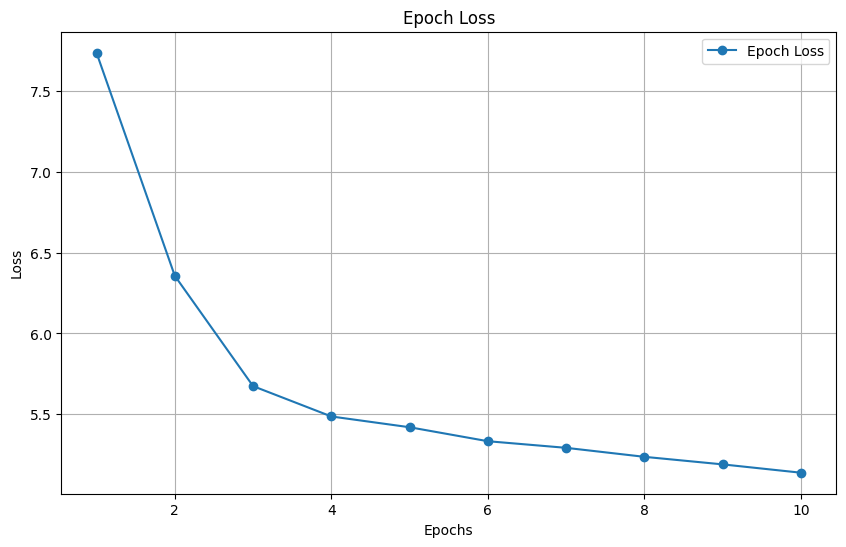

In [21]:
import matplotlib.pyplot as plt

# Plotting the epoch loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), epoch_loss_values, label='Epoch Loss', marker='o')
plt.title('Epoch Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

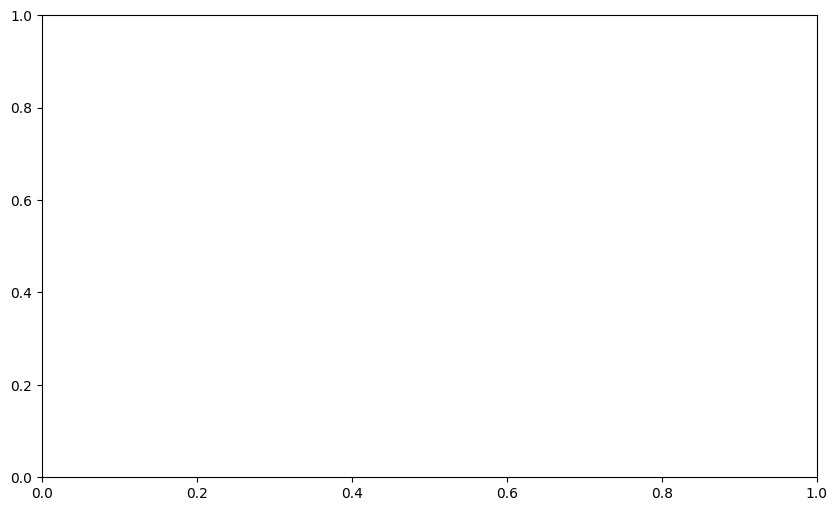

In [23]:
# Plotting epoch accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), epoch_accuracy_values, label='Epoch Accuracy', marker='o')
plt.title('Epoch Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Transformer model: Generate results

TypeError: Transformer.call() missing 3 required positional arguments: 'enc_padding_mask', 'look_ahead_mask', and 'dec_padding_mask'

In [24]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Assuming you have loaded your trained Transformer model and tokenizer
# Load your trained Transformer model
transformer_model = tf.keras.models.load_model(transformer)

# Load the tokenizer used during training
tokenizer = Tokenizer()
tokenizer.fit_on_texts(your_corpus)  # Update with the corpus used for training

# Function to generate response
def generate_response(input_text):
    # Tokenize the input text
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_input_length, padding='post')  # Update with the max input length

    # Initialize the decoder input with SOS token
    decoder_input = tf.expand_dims([tokenizer.word_index['']])

    # Initialize empty response string
    response = ''

    # Set the maximum sequence length for the decoder output
    max_output_length = 100  # Update with your desired maximum length

    for i in range(max_output_length):
        # Generate predictions from the model
        predictions = transformer_model([input_seq, decoder_input], training=False)
        # Get the predicted word index
        predicted_id = tf.argmax(predictions, axis=-1)

        # Convert the predicted word index to word
        predicted_word = tokenizer.index_word[predicted_id.numpy()[0][0]]

        # If the predicted word is the end-of-sequence token, break the loop
        if predicted_word == '':
            break

        # Append the predicted word to the response string
        response += predicted_word + ' '

        # Update the decoder input for the next iteration
        decoder_input = tf.expand_dims([predicted_id.numpy()[0][0]], 0)

    return response.strip()

# Example usage
input_text = 'How are you?'
response = generate_response(input_text)
print('Response:', response)


OSError: Unable to load model. Filepath is not an hdf5 file (or h5py is not available) or SavedModel. Received: filepath=<__main__.Transformer object at 0x7ab872f196c0>